## Stack warping example

This tutorial ilustrates how to load data along with the allen areas and landmark file.
Steps: 
1. load data U and SVT onto SVDStack
2. load the landmark file (contains the points and transform saved from the GUI)
3. load the reference regions (these are in allen coordinates - to be able to use diferent camera/frame sizes)
4. transform the images on the stack to match the reference (``stack.set_warped(True,lmarks['transform'])``) 

In [4]:
from wfield import *

U = np.load('U.npy')
SVT = np.load('SVTcorr.npy')
stack = SVDStack(U,SVT)
lmarks = load_allen_landmarks('dorsal_cortex_landmarks.json')

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
# the reference is in allen CCF space and needs to be converted
# this converts to warped image space (accounting for the transformation)
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
atlas, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json') # this loads the atlas in transformed coords

# this does the transform (warps the original images)
stack.set_warped(1, M = lmarks['transform']) # this warps the spatial components in the stack


For comparisson we will also load the atlas and regions in image space (before warping)

You can alternate between warped and unwarped using the stack.set_warped method.

To use unwarped: ``stack.set_warped(False)``

In [5]:
# this converts the reference to image space (unwarped)
atlas_im, areanames, brain_mask = atlas_from_landmarks_file('dorsal_cortex_landmarks.json',do_transform = True) # this loads the untransformed atlas
ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])


### Extract raw activity using warped or raw atlases

Use the method get_timecourse from the stack object. 
This method accepts the indices of the atlas region.

``pixeldata = stack.get_timecourse(np.where(atlas == AREA_NUMBER))``

The area-number correspondence is in the areanames variable. 

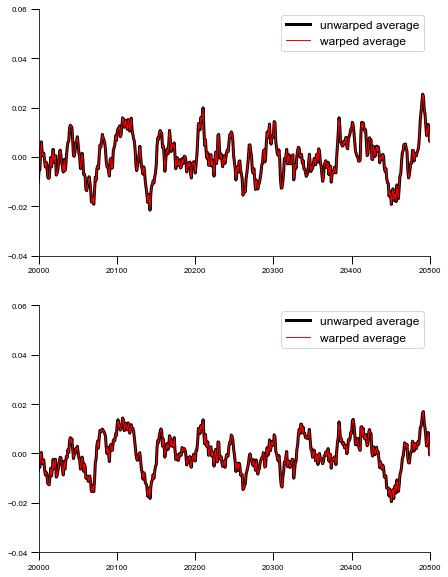

In [13]:
# Lets compare the warped with the unwarped average activity in an area
# area 20 is Aud
area = 20
stack.set_warped(True) # once this is done once the transform is set and you can alternate between the 2 modes.
warped = stack.get_timecourse(np.where(atlas == area)).mean(axis = 0)
stack.set_warped(False)
unwarped = stack.get_timecourse(np.where(atlas_im == area)).mean(axis = 0)

fig = plt.figure(figsize = [7,10])
fig.add_subplot(2,1,1)
plt.plot(unwarped,'k',lw = 3,label = 'unwarped average')
plt.plot(warped,'r',lw = 1,label = 'warped average')
plt.legend()
plt.xlim([20000,20500])
plt.ylim([-0.04,0.06]);

area = -20 # plot the other side
stack.set_warped(True) 
warped = stack.get_timecourse(np.where(atlas == area)).mean(axis = 0)
stack.set_warped(False)
unwarped = stack.get_timecourse(np.where(atlas_im == area)).mean(axis = 0)

fig.add_subplot(2,1,2)
plt.plot(unwarped,'k',lw = 3,label = 'unwarped average')
plt.plot(warped,'r',lw = 1,label = 'warped average')
plt.legend()
plt.xlim([20000,20500])
plt.ylim([-0.04,0.06]);

### Plot the first 20 spatial components of the transformed dataset and the raw dataset

The stack object stores the originalU and the warped U.

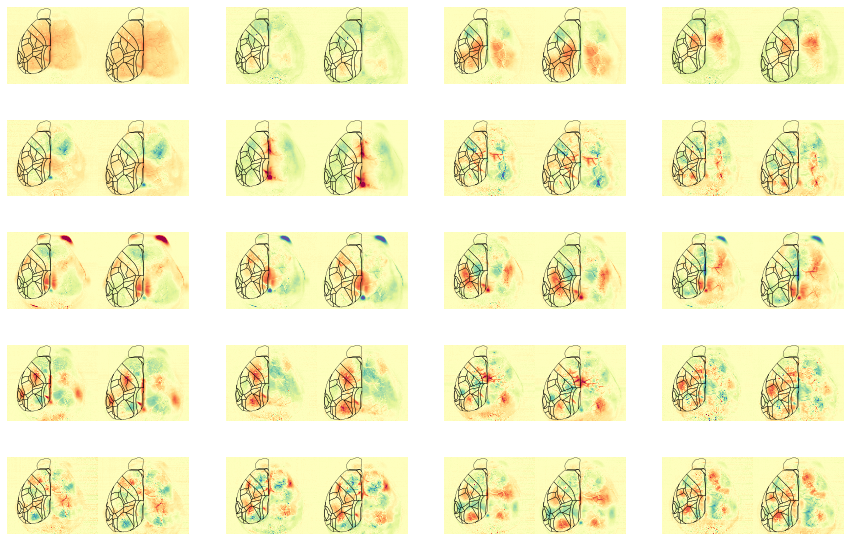

In [15]:
# Plot the first 20 spatial components of the transformed dataset and the raw dataset
fig = plt.figure(figsize = [15,10])
ncomponents = 20
for icomponent in range(ncomponents):
    fig.add_subplot(5,4,icomponent+1)
    plt.imshow(np.concatenate([stack.originalU[:,:,icomponent],
                               stack.U_warped[:,:,icomponent]],axis = 1),
               clim=[-0.01,0.01],cmap='Spectral_r')
    # plot the regions overlayed on the raw images
    for i,r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'],r['left_y'],'k',lw=0.3)
    # plot the raw reference because the images were converted
    for i,r in ccf_regions.iterrows():
        plt.plot(np.array(r['left_x'])+stack.U.shape[1],r['left_y'],'k',lw=0.3)
    plt.axis('off')

### Plot 20 random frames of the transformed dataset and the raw dataset 
(sanity check: what does the transform do to the images)

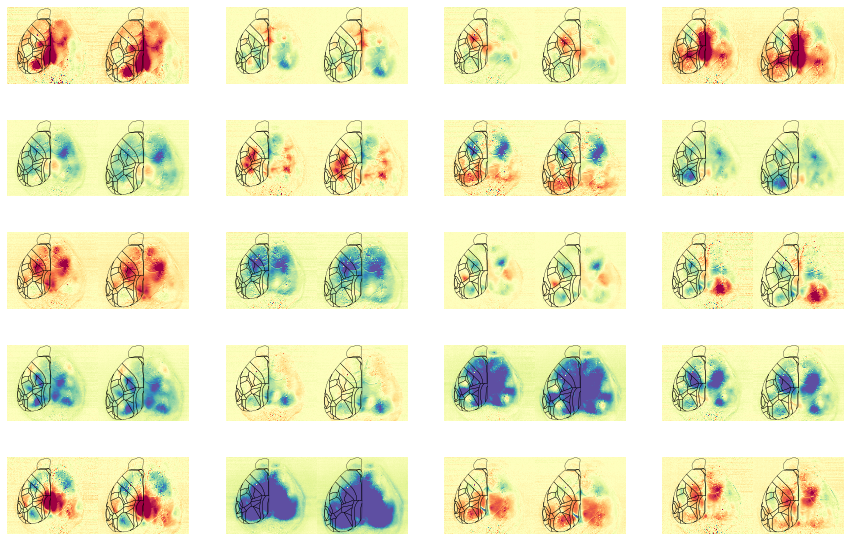

In [16]:
# Plot the 20 frames of the transformed dataset and the raw dataset
fig = plt.figure(figsize = [15,10])
for i,iframe in enumerate(np.random.choice(np.arange(0,stack.shape[0]),20)):
    fig.add_subplot(5,4,i+1)
    plt.imshow(np.concatenate([reconstruct(stack.originalU,stack.SVT[:,iframe]),
                               reconstruct(stack.U_warped,stack.SVT[:,iframe])],axis = 1),
               clim=[-0.03,0.03],cmap='Spectral_r')
    # plot the regions overlayed on the raw images
    for i,r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'],r['left_y'],'k',lw=0.3)
    # plot the raw reference because the images were converted
    for i,r in ccf_regions.iterrows():
        plt.plot(np.array(r['left_x'])+stack.U.shape[1],r['left_y'],'k',lw=0.3)
    plt.axis('off')

## Highlight the differences in the atlas and ROIs in both warped and raw spaces

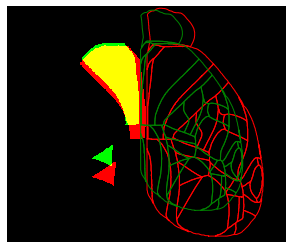

In [8]:
# Plot the overlap for the same region in the warped versus unwarped atlases 
plt.figure(figsize = [5,5])
area1 = 4
area2 = 32
reg = np.zeros([*atlas.shape,3])
reg[:,:,0] = np.array((atlas == area1) | (atlas == area2))*255
reg[:,:,1] = np.array((atlas_im == area1) | (atlas_im == area2))*255
plt.imshow(reg.astype('uint8'))

for i,r in ccf_regions.iterrows():
    for side in ['right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'r',lw=1)
for i,r in ccf_regions_im.iterrows():
    for side in ['right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'g',lw=1)
plt.axis('off');

### Explore the converted stack on the notebook

In [ ]:
%matplotlib notebook

In [ ]:
# play a movie of the stack with the regions overlayed
fig = plt.figure()
# This is for stack.set_warped(True)
stack.set_warped(True)
for i,r in ccf_regions.iterrows():
    for side in ['left','right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'k',lw=0.3)
plt.axis('off')
nb_play_movie(stack,cmap = 'Spectral_r',clim=[-0.04,0.04])
